## Dance move prediction using Multilayer Perceptron (MLP)

#### Summary:
- Using sklearn's MLP
- no feature extraction - trained entirely on raw data
- segmentation window selected based on trial and error
- using batch_size = 36 for model training, see justifications below
- average result: ~81% accuracy after multiple hyperparameters tuning
- average result derived from 5-fold cross validation with shuffled training and test dataset

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.neural_network as nn
import pickle
from glob import glob
from timeit import default_timer as timer
import sys
from GraphingAndTransfer.extractDataset import *

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from tune_sklearn import TuneGridSearchCV

from keras.utils import np_utils,to_categorical
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import optimizers

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
# plt.style.use('bmh')

file_path = "GraphingAndTransfer/processed/*"

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
np.set_printoptions(threshold=10000) # 'sys.maxsize' for max

### Define segmentation window

In [2]:
NUMBER_OF_AFTER_SAMPLES = 8 #Number of samples to include in dance move after end detected
NUMBER_OF_BEFORE_SAMPLES = 8 #Number of samples to include in dance move before start detected
MINIMUM_MOVE_TIME = 20 #Minimum number of samples to be considered a move. Set this too low and you will get garbage dance samples

In [3]:
danceMoveDataset = processData(NUMBER_OF_AFTER_SAMPLES, NUMBER_OF_BEFORE_SAMPLES, MINIMUM_MOVE_TIME)

Recording from dev2 with move pointhigh at 16152387977925 opened with 685 samples
Recording from dev2 with move hair at 16152385941495 opened with 898 samples
Recording from dev2 with move dab at 16152380133389 opened with 786 samples
Recording from dev2 with move pointhigh at 16152388450418 opened with 188 samples
Recording from dev2 with move listen at 16152386837158 opened with 703 samples
Recording from dev2 with move gun at 16152384604594 opened with 903 samples
Recording from dev2 with move elbowkick at 16152382981181 opened with 1498 samples
Recording from dev2 with move sidepump at 16152389923805 opened with 754 samples
Recording from dev2 with move wipetable at 16152391069694 opened with 881 samples
Done
Extracted 87 moves from 9 raw data Sequences.
10  dab
10  elbowkick
12  gun
11  hair
12  listen
11  pointhigh
10  sidepump
11  wipetable
0  defaultMove


### Visualise each move sample in the segmentation window defined above

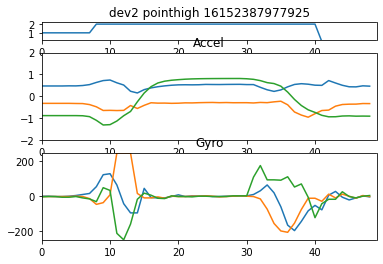

<Figure size 432x288 with 0 Axes>

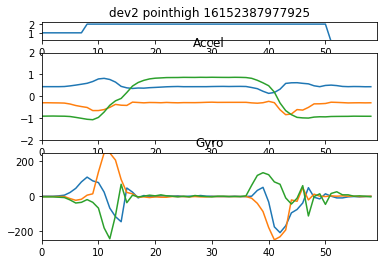

<Figure size 432x288 with 0 Axes>

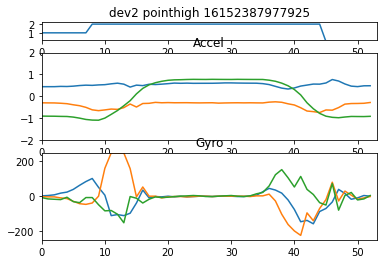

<Figure size 432x288 with 0 Axes>

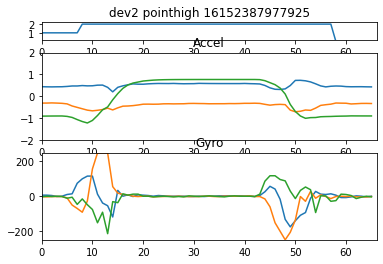

<Figure size 432x288 with 0 Axes>

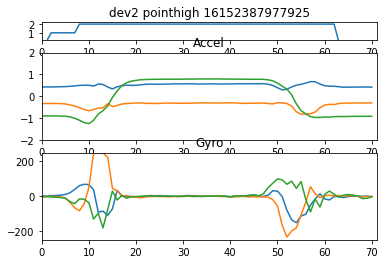

<Figure size 432x288 with 0 Axes>

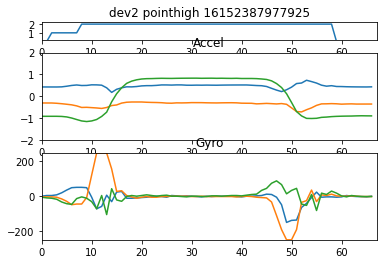

<Figure size 432x288 with 0 Axes>

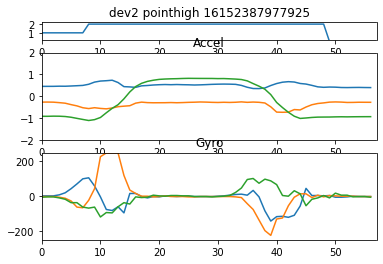

<Figure size 432x288 with 0 Axes>

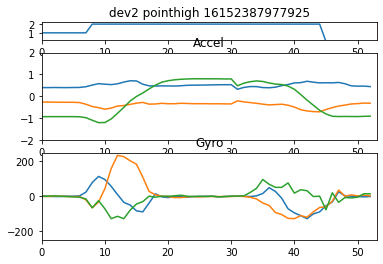

<Figure size 432x288 with 0 Axes>

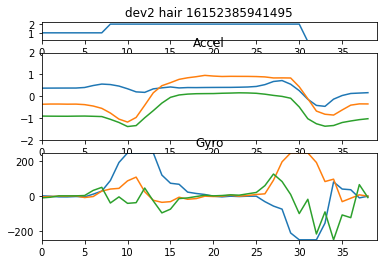

<Figure size 432x288 with 0 Axes>

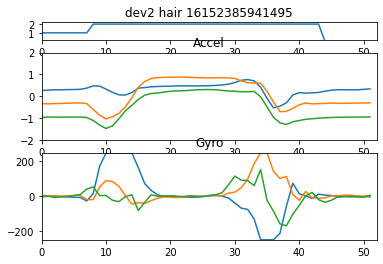

<Figure size 432x288 with 0 Axes>

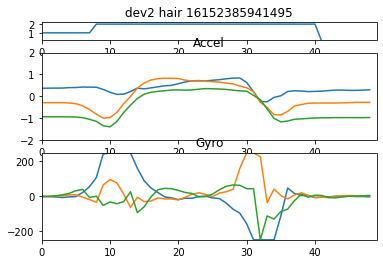

<Figure size 432x288 with 0 Axes>

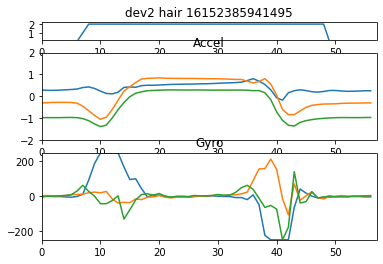

<Figure size 432x288 with 0 Axes>

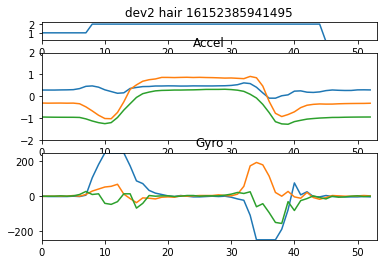

<Figure size 432x288 with 0 Axes>

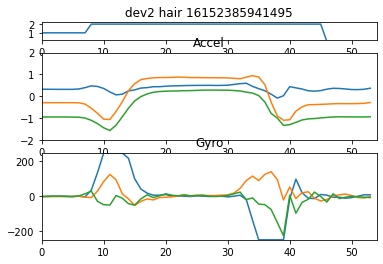

<Figure size 432x288 with 0 Axes>

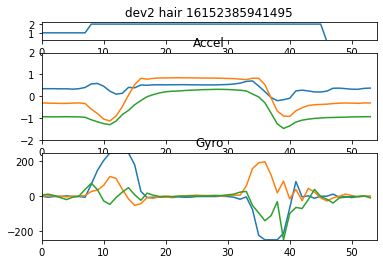

<Figure size 432x288 with 0 Axes>

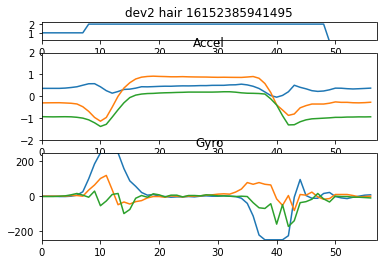

<Figure size 432x288 with 0 Axes>

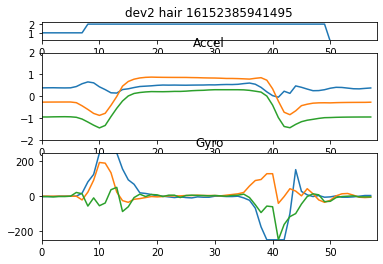

<Figure size 432x288 with 0 Axes>

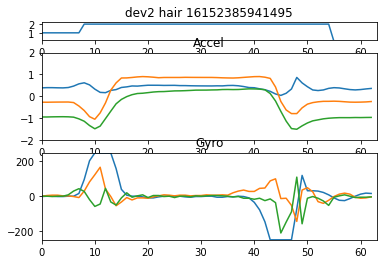

<Figure size 432x288 with 0 Axes>

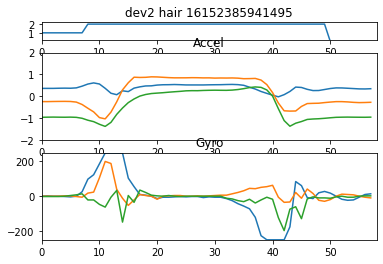

<Figure size 432x288 with 0 Axes>

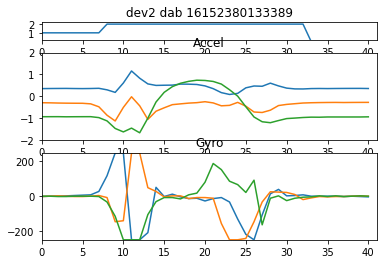

<Figure size 432x288 with 0 Axes>

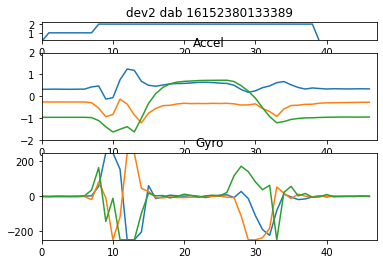

<Figure size 432x288 with 0 Axes>

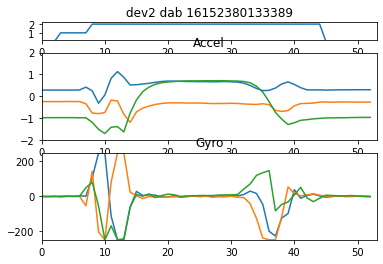

<Figure size 432x288 with 0 Axes>

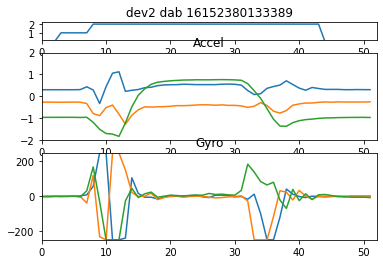

<Figure size 432x288 with 0 Axes>

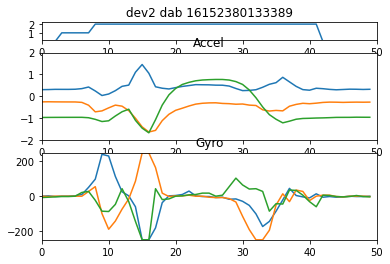

<Figure size 432x288 with 0 Axes>

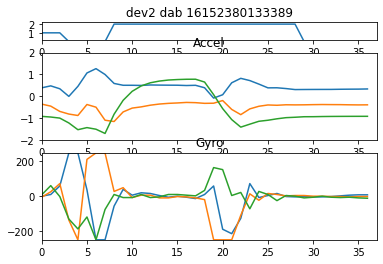

<Figure size 432x288 with 0 Axes>

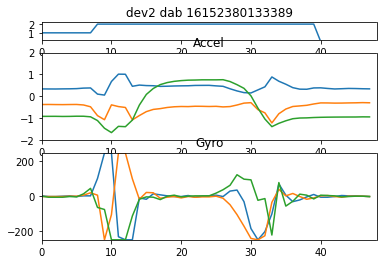

<Figure size 432x288 with 0 Axes>

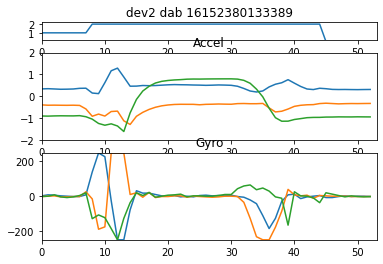

<Figure size 432x288 with 0 Axes>

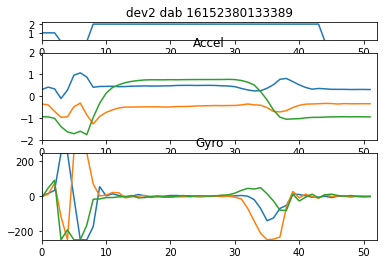

<Figure size 432x288 with 0 Axes>

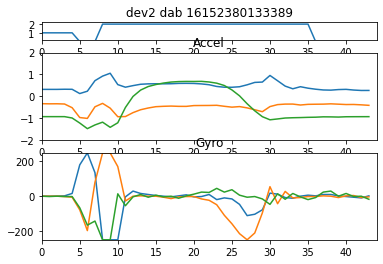

<Figure size 432x288 with 0 Axes>

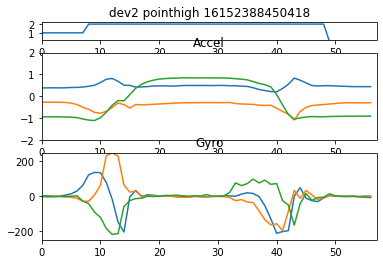

<Figure size 432x288 with 0 Axes>

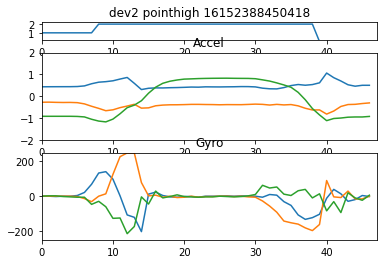

<Figure size 432x288 with 0 Axes>

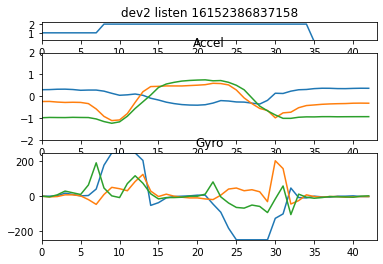

<Figure size 432x288 with 0 Axes>

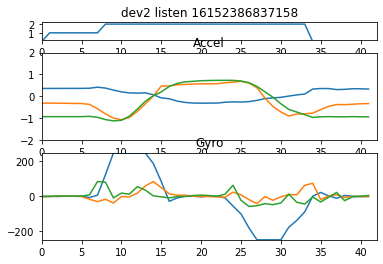

<Figure size 432x288 with 0 Axes>

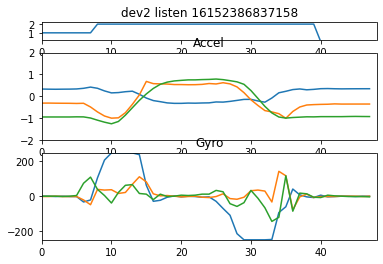

<Figure size 432x288 with 0 Axes>

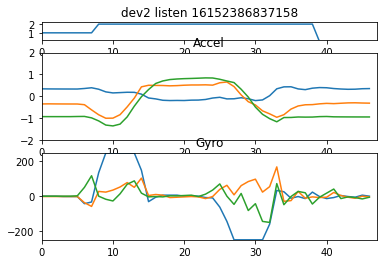

<Figure size 432x288 with 0 Axes>

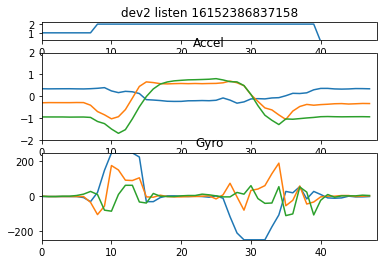

<Figure size 432x288 with 0 Axes>

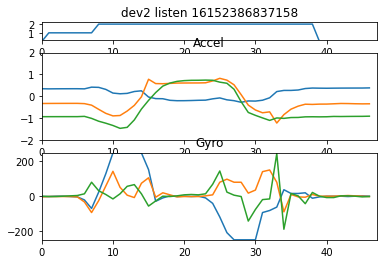

<Figure size 432x288 with 0 Axes>

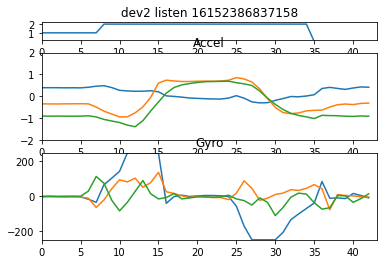

<Figure size 432x288 with 0 Axes>

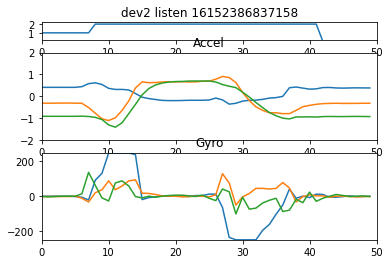

<Figure size 432x288 with 0 Axes>

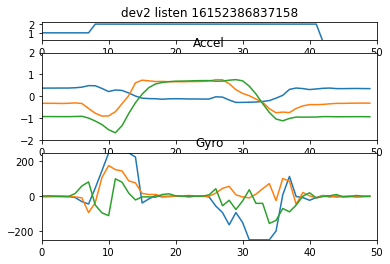

<Figure size 432x288 with 0 Axes>

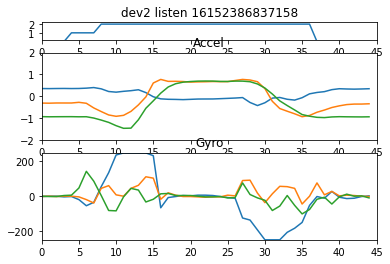

<Figure size 432x288 with 0 Axes>

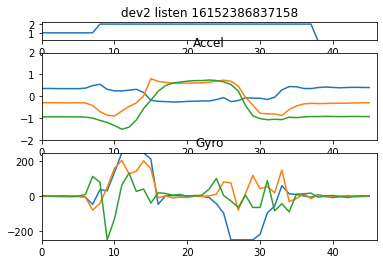

<Figure size 432x288 with 0 Axes>

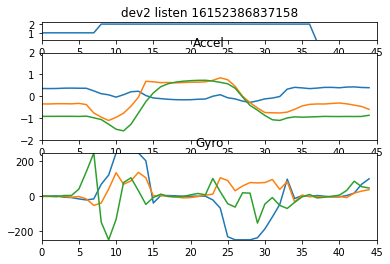

<Figure size 432x288 with 0 Axes>

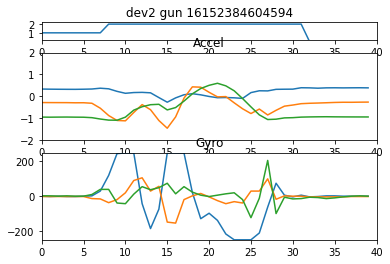

<Figure size 432x288 with 0 Axes>

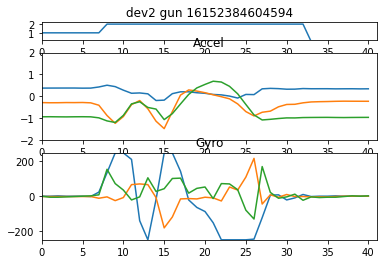

<Figure size 432x288 with 0 Axes>

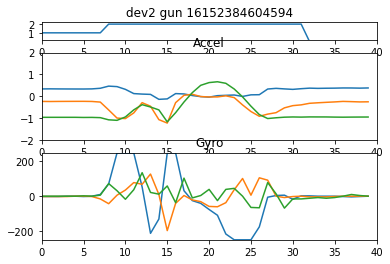

<Figure size 432x288 with 0 Axes>

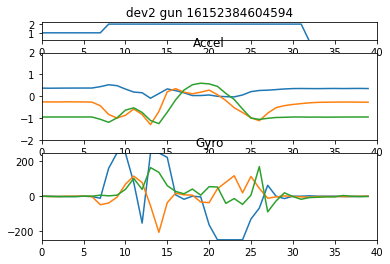

<Figure size 432x288 with 0 Axes>

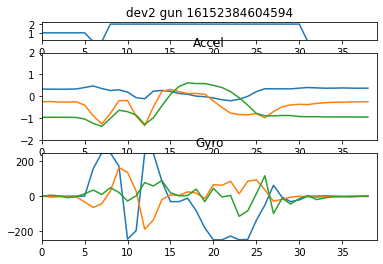

<Figure size 432x288 with 0 Axes>

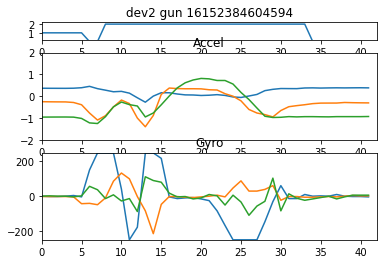

<Figure size 432x288 with 0 Axes>

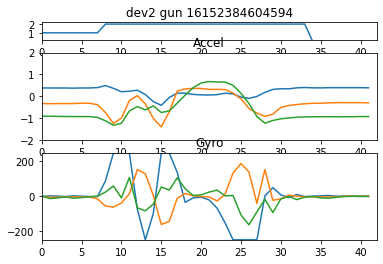

<Figure size 432x288 with 0 Axes>

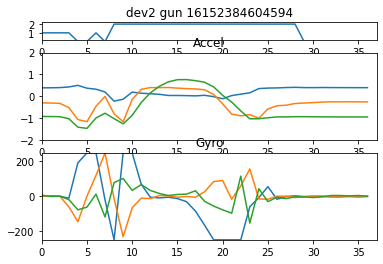

<Figure size 432x288 with 0 Axes>

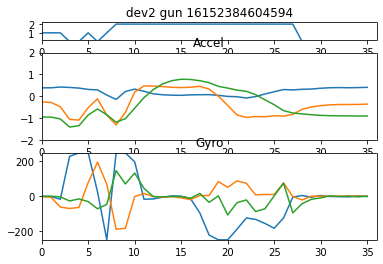

<Figure size 432x288 with 0 Axes>

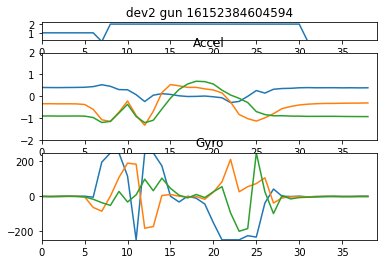

<Figure size 432x288 with 0 Axes>

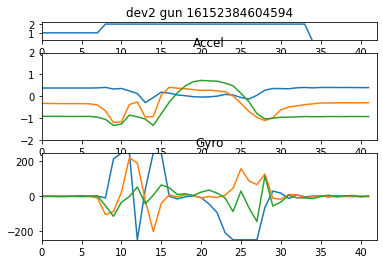

<Figure size 432x288 with 0 Axes>

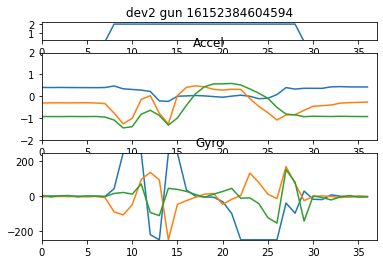

<Figure size 432x288 with 0 Axes>

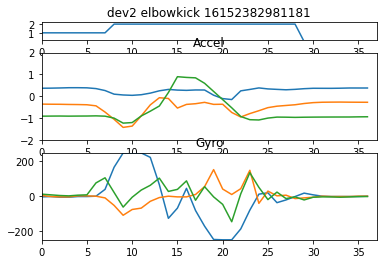

<Figure size 432x288 with 0 Axes>

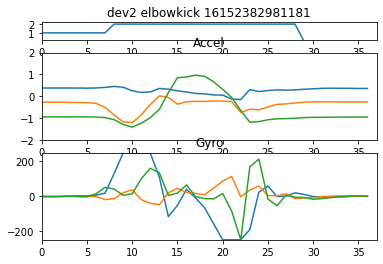

<Figure size 432x288 with 0 Axes>

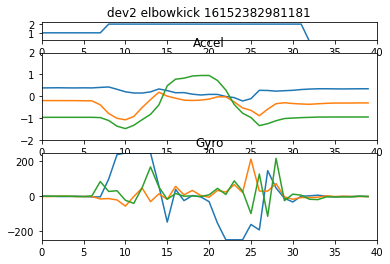

<Figure size 432x288 with 0 Axes>

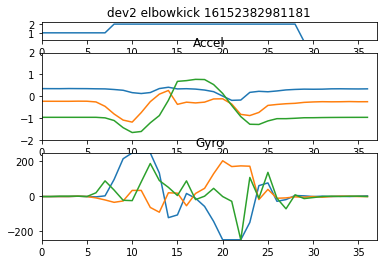

<Figure size 432x288 with 0 Axes>

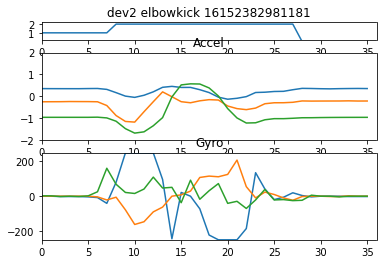

<Figure size 432x288 with 0 Axes>

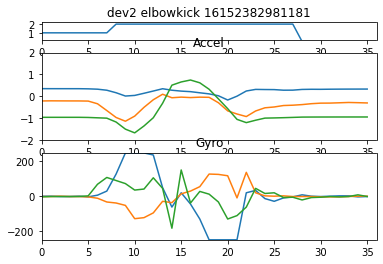

<Figure size 432x288 with 0 Axes>

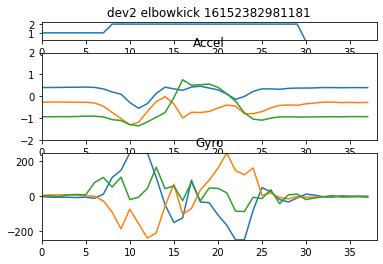

<Figure size 432x288 with 0 Axes>

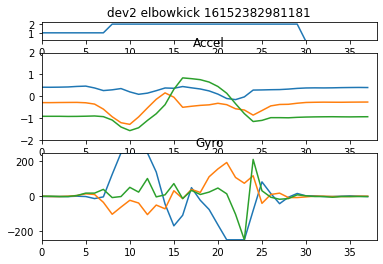

<Figure size 432x288 with 0 Axes>

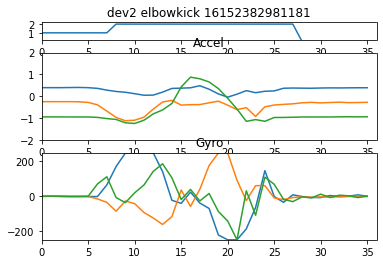

<Figure size 432x288 with 0 Axes>

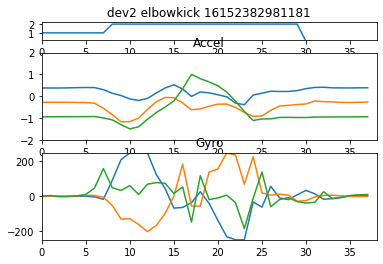

<Figure size 432x288 with 0 Axes>

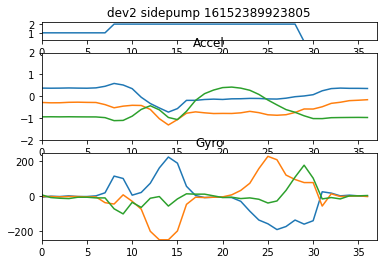

<Figure size 432x288 with 0 Axes>

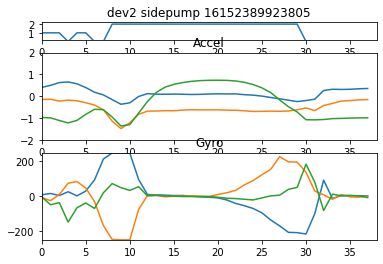

<Figure size 432x288 with 0 Axes>

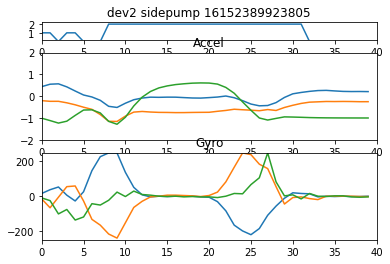

<Figure size 432x288 with 0 Axes>

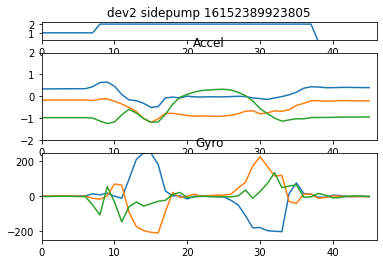

<Figure size 432x288 with 0 Axes>

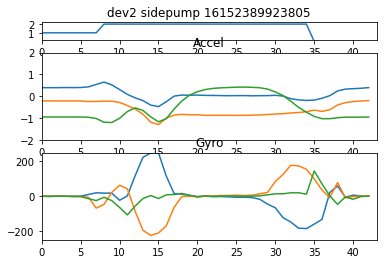

<Figure size 432x288 with 0 Axes>

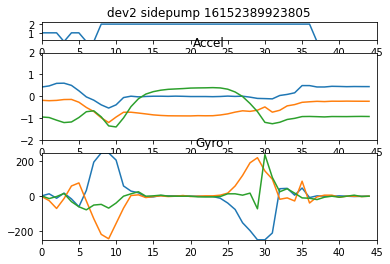

<Figure size 432x288 with 0 Axes>

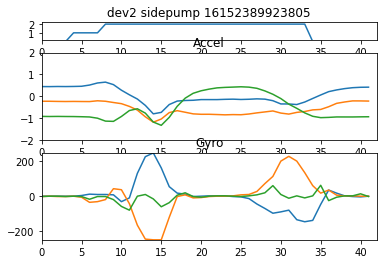

<Figure size 432x288 with 0 Axes>

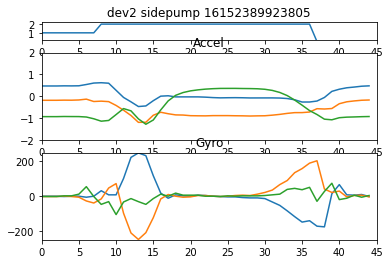

<Figure size 432x288 with 0 Axes>

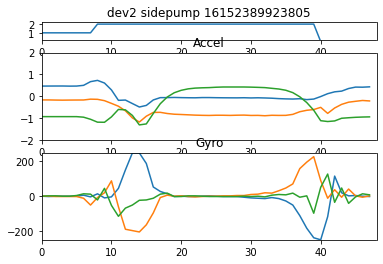

<Figure size 432x288 with 0 Axes>

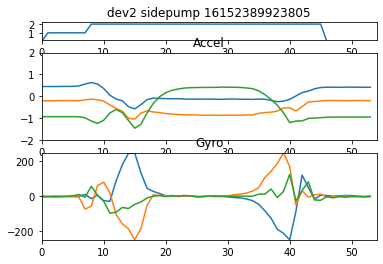

<Figure size 432x288 with 0 Axes>

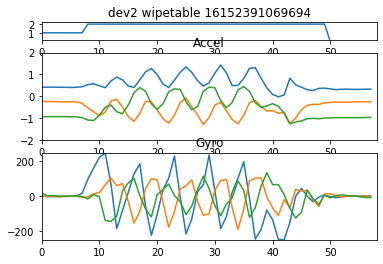

<Figure size 432x288 with 0 Axes>

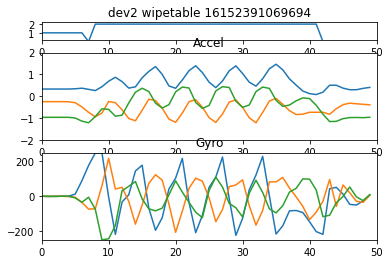

<Figure size 432x288 with 0 Axes>

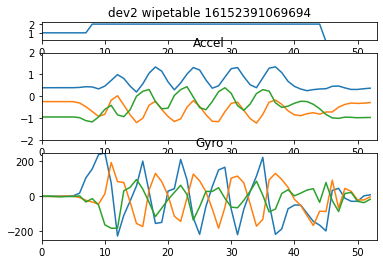

<Figure size 432x288 with 0 Axes>

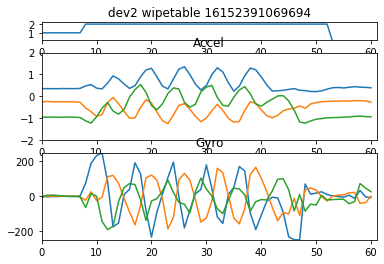

<Figure size 432x288 with 0 Axes>

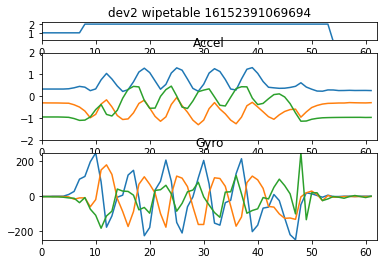

<Figure size 432x288 with 0 Axes>

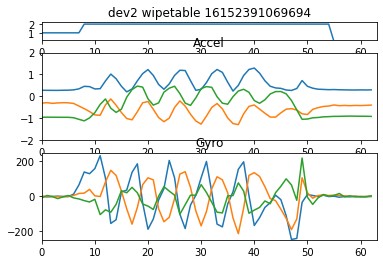

<Figure size 432x288 with 0 Axes>

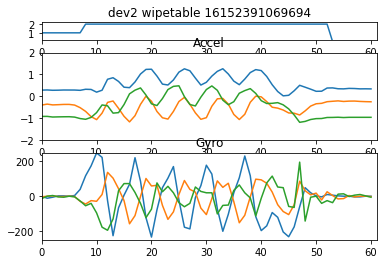

<Figure size 432x288 with 0 Axes>

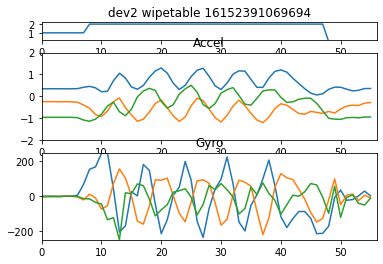

<Figure size 432x288 with 0 Axes>

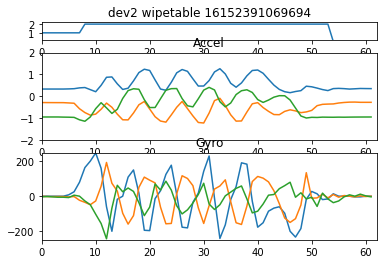

<Figure size 432x288 with 0 Axes>

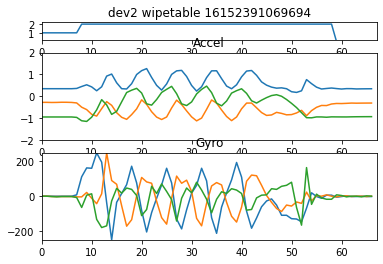

<Figure size 432x288 with 0 Axes>

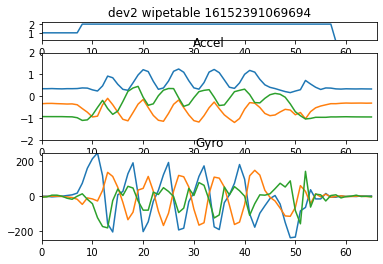

<Figure size 432x288 with 0 Axes>

In [4]:
for i in range (1, len(danceMoveDataset)):
    danceMoveDataset[i].plot()

### Number of series of samples in each move, based on the segmentation window defined above.

In [5]:
folder_path = "GraphingAndTransfer/processed/"
noOfSamples = []
for text_file in sorted(os.listdir(folder_path)):
    print("Processing:", text_file)
    
    with open(folder_path+text_file, 'r') as f:
        file = f.readlines()[1:]
    print("Number of series of samples in this move =", np.asarray(file).shape[0], "\n")
    
    noOfSamples.append(np.asarray(file).shape[0])

Processing: dev2_dab_16152380133389_19
Number of series of samples in this move = 38 

Processing: dev2_dab_16152380133389_20
Number of series of samples in this move = 41 

Processing: dev2_dab_16152380133389_21
Number of series of samples in this move = 47 

Processing: dev2_dab_16152380133389_22
Number of series of samples in this move = 53 

Processing: dev2_dab_16152380133389_23
Number of series of samples in this move = 52 

Processing: dev2_dab_16152380133389_24
Number of series of samples in this move = 50 

Processing: dev2_dab_16152380133389_25
Number of series of samples in this move = 37 

Processing: dev2_dab_16152380133389_26
Number of series of samples in this move = 48 

Processing: dev2_dab_16152380133389_27
Number of series of samples in this move = 53 

Processing: dev2_dab_16152380133389_28
Number of series of samples in this move = 52 

Processing: dev2_dab_16152380133389_29
Number of series of samples in this move = 44 

Processing: dev2_elbowkick_16152382981181_5

### Min, max of all datasets

In [6]:
minSamples = min(noOfSamples)
maxSamples = max(noOfSamples)
print("Minimum: {} \nMaximum: {}" .format(minSamples, maxSamples))

Minimum: 36 
Maximum: 71


### Selecting only the first 36 series of samples in each move and append in to a dataframe in order

In [7]:
columns = ['acc_X','acc_Y','acc_Z','gyro_X','gyro_Y','gyro_Z','Stage', 'Activity']
combined_raw = pd.DataFrame(columns = columns)

In [8]:
folder_path = "GraphingAndTransfer/processed/"
for text_file in sorted(os.listdir(folder_path)):
    print("Processing:", text_file)
    
    with open(folder_path+text_file, 'r') as f:
        file = f.readlines()[1:minSamples]
        
    temp_list = []
    
    for line in file:
        temp_list.append([float(value) for value in line.split(',')])
    
    print("Shape =", np.asarray(temp_list).shape, "\n")

    # file_path_name = os.path.splitext(text_file)[0]
    # activity_labels = file_path_name.split('_')[1]

    activity_labels = text_file.split('_')[1]
        
    raw_data = np.array(temp_list)
        
    df_raw = pd.DataFrame(data = raw_data, columns = ['acc_X','acc_Y','acc_Z','gyro_X','gyro_Y','gyro_Z','Stage'])
    df_raw['Activity'] = activity_labels
    combined_raw = combined_raw.append(df_raw)

combined_raw.reset_index(drop=True, inplace=True)

Processing: dev2_dab_16152380133389_19
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_20
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_21
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_22
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_23
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_24
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_25
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_26
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_27
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_28
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_29
Shape = (35, 7) 

Processing: dev2_elbowkick_16152382981181_56
Shape = (35, 7) 

Processing: dev2_elbowkick_16152382981181_57
Shape = (35, 7) 

Processing: dev2_elbowkick_16152382981181_58
Shape = (35, 7) 

Processing: dev2_elbowkick_16152382981181_59
Shape = (35, 7) 

Processing: dev2_elbowkick_16152382981181_60
Shape = (35, 7) 

Processing: dev2_elbowkick_16152382981181_61
Shape = (35, 

In [9]:
combined_raw

,acc_X,acc_Y,acc_Z,gyro_X,gyro_Y,gyro_Z,Stage,Activity
0,0.347305,-0.299063,-0.941626,-1.953125,-1.953125,0.000000,1.0,dab
1,0.352133,-0.304438,-0.939976,0.000000,0.000000,0.000000,1.0,dab
2,0.355030,-0.313913,-0.938985,0.000000,1.953125,-1.953125,1.0,dab
3,0.356768,-0.319598,-0.944641,1.953125,0.000000,-1.953125,1.0,dab
4,0.351561,-0.323009,-0.941785,3.906250,-1.953125,0.000000,1.0,dab
...,...,...,...,...,...,...,...,...
3915,0.381768,-1.120911,-0.068856,21.484375,-74.218750,3.906250,2.0,wipetable
3916,0.322811,-1.185047,0.208687,113.281250,-166.015625,78.125000,2.0,wipetable
3917,0.624937,-0.892278,0.268962,173.828125,-152.343750,62.500000,2.0,wipetable
3918,1.106212,-0.529117,0.298877,44.921875,15.625000,-21.484375,2.0,wipetable


In [10]:
X = combined_raw.iloc[:,:-2]
y = combined_raw.iloc[:, -1]

In [11]:
X

,acc_X,acc_Y,acc_Z,gyro_X,gyro_Y,gyro_Z
0,0.347305,-0.299063,-0.941626,-1.953125,-1.953125,0.000000
1,0.352133,-0.304438,-0.939976,0.000000,0.000000,0.000000
2,0.355030,-0.313913,-0.938985,0.000000,1.953125,-1.953125
3,0.356768,-0.319598,-0.944641,1.953125,0.000000,-1.953125
4,0.351561,-0.323009,-0.941785,3.906250,-1.953125,0.000000
...,...,...,...,...,...,...
3915,0.381768,-1.120911,-0.068856,21.484375,-74.218750,3.906250
3916,0.322811,-1.185047,0.208687,113.281250,-166.015625,78.125000
3917,0.624937,-0.892278,0.268962,173.828125,-152.343750,62.500000
3918,1.106212,-0.529117,0.298877,44.921875,15.625000,-21.484375


In [12]:
y

0             dab
1             dab
2             dab
3             dab
4             dab
          ...    
3915    wipetable
3916    wipetable
3917    wipetable
3918    wipetable
3919    wipetable
Name: Activity, Length: 3920, dtype: object

In [13]:
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
y = encoder.fit_transform(y)

In [14]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
encoder.classes_

array(['dab', 'elbowkick', 'gun', 'hair', 'listen', 'pointhigh',
       'sidepump', 'wipetable'], dtype=object)

In [16]:
cm_hist = []
classification_report_hist = []

### Search for optimal hyperparameters using Tune Search (https://github.com/ray-project/tune-sklearn)

In [ ]:
# Bad: always exceed epoch limit without convergence. To be considered in future.
def tuneSearch():
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=None, shuffle=True)

    mlp_adam = nn.MLPClassifier(solver='adam', early_stopping=True, batch_size=32)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    tune_parameters = {
        'hidden_layer_sizes': [(100,200), (150,200), (200, 150), (50, 200, 3)],
        'activation': ['tanh', 'relu'],
        'solver': ['adam'],
        'alpha': [1e-4, 1e-1, 0.05],
        'epsilon':[0.01, 0.1]
    }
    
    tune_search = TuneGridSearchCV(
        mlp_adam,
        tune_parameters,
        early_stopping=True,
        max_iters=10
    )
    
    tune_search.fit(X_train, y_train)
    pred = tune_search.predict(X_test)
    accuracy = np.count_nonzero(np.array(pred) == np.array(y_test)) / len(pred)
    print("Tune Accuracy:", accuracy)
    print(tune_search.best_params_)

### Search for optimal hyperparameters using GridSearchCV

In [ ]:
def GSCV():
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

    mlp_adam = nn.MLPClassifier(solver='adam', early_stopping=True, batch_size=minSamples)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
#     print('X_train:', X_train)
#     print('X_test:', X_test)
#     print('y_train:', y_train)
#     print('y_test:', y_test)

    parameter_space = {
        'hidden_layer_sizes': [(100,200), (150,200), (200, 150), (50,200,3),
                               (50,100,50), (100,), (200,), (300,), (400,)],
        'activation': ['tanh', 'relu'],
        'alpha': [0.0001, 0.001, 0.05],
        'tol': [1e-4, 1e-5, 1e-6]        
    }
    
        
    clf = GridSearchCV(mlp_adam, parameter_space, scoring='accuracy', n_jobs=-1, cv=3, verbose=3)
    clf.fit(X_train, y_train)
        
    print('Best parameters found:\n', clf.best_params_)

#     # All results
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
    mlp_pred = clf.predict(X_test)
    
    print('Results on the test set:')
    print(classification_report(y_test, mlp_pred, target_names=encoder.classes_))

In [ ]:
GSCV()

#### Note the optimal hyperparameters found above are just indicative

### CNN Training

In [17]:
def perform_mlp(fold, pca):
    start_time = timer()
    k = fold
    perform_pca = pca
    kf = KFold(n_splits=k, shuffle=True)
    #kf = StratifiedKFold(n_splits=k, shuffle=True)

# MLP SGD model - not used bc of poor accuracy
#     mlp_sgd_model = nn.MLPClassifier(hidden_layer_sizes=(500,), max_iter=300, activation='relu', solver='sgd',
#                                      batch_size = minSamples,
#                                      alpha=1e-4, early_stopping=True, verbose=1, tol=1e-6, random_state=0,
#                                      learning_rate_init=0.001, shuffle=True)

# Trial 1: ave accuracy 80%
#     mlp_adam = nn.MLPClassifier(hidden_layer_sizes=(150,200), max_iter=500, activation='relu', solver='adam',
#                                       batch_size = minSamples, validation_fraction=0.2, n_iter_no_change=20,
#                                       alpha=1e-4, early_stopping=True, verbose=0, tol=1e-6, random_state=None, 
#                                       learning_rate_init=0.001, shuffle=False) 

# Trial 2: ave accuracy 77%
#     mlp_adam = nn.MLPClassifier(hidden_layer_sizes=(50,100,50), max_iter=500, activation='relu', solver='adam',
#                                       batch_size = minSamples, validation_fraction=0.2, n_iter_no_change=20,
#                                       alpha=1e-3, early_stopping=True, verbose=0, tol=1e-5, random_state=None, 
#                                       learning_rate_init=0.001, shuffle=False) 

# Trial 3: ave accuracy 81%
    mlp_adam = nn.MLPClassifier(hidden_layer_sizes=(200, 150), max_iter=500, activation='tanh', solver='adam',
                                      batch_size = minSamples, validation_fraction=0.2, n_iter_no_change=20,
                                      alpha=1e-4, early_stopping=True, verbose=0, tol=1e-6, random_state=None, 
                                      learning_rate_init=0.001, shuffle=False) 

    acc_scores_mlp_sgd = []
    acc_scores_mlp_adam = []
    cv_iteration = 1
    cv_pca_iteration = 1
    cm_hist.clear()
    classification_report_hist.clear()
#     train_histories_mlp_sgd.clear()
#     train_histories_mlp_adam.clear()
    
    for train_index, test_index in kf.split(X):
        
        if perform_pca == False:
            print('\nTraining model and cross validate using fold #{}...\n ' .format(cv_iteration))
            cv_iteration += 1
        
        X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        if perform_pca == True:
            print('\nTraining model with PCA and cross validate using fold #{}...\n ' .format(cv_pca_iteration))
            cv_pca_iteration += 1
            pca = PCA(n_components = 6) # n=100 is the usual consensus in HAR
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
            pca.explained_variance_ratio_

#         mlp_sgd_model.fit(X_train, y_train)
#         pred_values_mlp_sgd = mlp_sgd_model.predict(X_test)
#         acc_sgd = accuracy_score(pred_values_mlp_sgd, y_test)
#         acc_scores_mlp_sgd.append(acc_sgd)

        mlp_adam.fit(X_train, y_train)
        pred_mlp_adam = mlp_adam.predict(X_test)
        print('pred_values_mlp_adam:\n', pred_mlp_adam)
        print('')
        print('y_test:\n', y_test)
        acc_adam = accuracy_score(pred_mlp_adam, y_test)
        acc_scores_mlp_adam.append(acc_adam)
        
        # Saving model weights via pickle
        filename = 'mlp_approach_1_weights.sav'
        pickle.dump(mlp_adam, open(filename, 'wb'))
        
        cm_hist.append(confusion_matrix(y_test, pred_mlp_adam))
        classification_report_hist.append(classification_report(y_test, pred_mlp_adam, target_names=encoder.classes_))
        
    end_time = timer()
    time_taken = end_time - start_time

    return acc_scores_mlp_adam, pred_mlp_adam, time_taken

In [18]:
acc_scores_mlp_adam, pred_mlp_adam, time_taken = perform_mlp(fold=5, pca=False)


Training model and cross validate using fold #1...
 
pred_values_mlp_adam:
 [4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 1 2 0
 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 5 3 2 1 1 1 1 1 1 4 0 2 2 2 2 4 1 1 4 7 2 1 2 1 4 2 1 0 1 1 1 1 4
 1 1 4 1 1 0 7 1 6 1 4 1 1 1 4 4 1 1 0 3 3 1 1 6 1 2 4 1 1 2 5 3 2 1 1 1 7
 1 1 2 1 1 2 5 2 1 1 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 4 0 0 2 2 0 1 2 2 2 2 2
 2 1 2 1 2 2 2 2 2 1 2 2 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 4
 2 2 4 2 2 2 2 4 2 1 2 2 2 2 2 2 5 2 2 1 2 2 0 6 6 3 2 2 2 2 2 2 4 6 2 2 2
 2 2 0 0 0 3 3 3 3 3 2 3 3 2 3 3 2 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 0
 3 3 3 3 3 3 3 4 0 4 3 3 2 3 3 3 3 4 4 3 3 3 3 3 4 3 3 3 3 3 3 3 3 1 1 5 4
 3 3 3 3 3 3 3 3 3 3 1 0 4 1 4 4 4 4 4 4 1 0 4 2 4 4 4 4 4 4 4 4 4 4 1 4 4
 2 4 4 4 2 0 4 4 4 2 0 4 4 4 0 0 4 4 4 2 4 0 4 1 4 4 0 4 4 4 4 2 2 2 4 4 4
 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 4 4 4 5 5 5 5 1 5 0 0 0 0
 5 5 5 5 5 5 0 5 5 5 5 

pred_values_mlp_adam:
 [4 0 0 0 0 4 0 0 0 0 2 0 0 0 0 5 0 0 0 0 6 0 0 0 0 0 0 6 0 5 5 0 0 0 0 0 5
 0 0 3 6 0 1 3 2 0 0 1 0 0 7 0 0 0 0 0 0 0 0 0 0 0 5 5 0 0 0 0 0 5 0 7 2 2
 4 1 1 1 1 2 1 1 6 6 1 2 7 1 1 5 1 1 7 7 1 1 1 6 6 1 1 1 1 2 1 1 1 2 7 1 1
 1 1 1 1 2 1 5 1 1 1 1 7 1 1 1 2 1 1 3 1 5 0 1 1 2 2 5 2 2 1 2 2 2 2 2 2 2
 2 2 4 2 2 1 2 2 2 5 2 2 2 2 1 3 1 2 2 1 1 1 1 2 2 2 7 2 4 2 2 2 2 2 1 2 1
 1 2 2 2 2 2 4 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 4 2 2 2 2 2 3 2 2 2 2 2 2
 2 2 2 2 3 3 4 3 3 3 1 3 3 1 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 5 3 3 3 3 3 1 3 4 3 3 1 3 3 3 3 3 3 1 4 2 3 3 3 3 3 5 3 3 3 3 3 6 4 4
 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 4 0 1 1 4 4 4 2 4 4 4 4 4 4 3 4 4 4 2 4 2
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 2 2 2 3 4 4 4 4 4 2 4 4 4 4
 4 4 4 4 4 4 4 4 4 2 4 4 4 4 2 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 1 0 5 5
 5 5 5 5 5 5 5 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 1 5 5 5 5 5 5 5 5 5 5 5
 5 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6
 6

In [19]:
print('MLP ADAM - prediction accuracy of each fold:\n {}'.format(acc_scores_mlp_adam))
print('')
print('MLP ADAM - average accuracy in 5-fold = {} with std. deviation {}' .format(np.mean(acc_scores_mlp_adam), np.std(acc_scores_mlp_adam)))
print('')
print('Time taken: {:.2f} seconds' .format(time_taken))

MLP ADAM - prediction accuracy of each fold:
 [0.7844387755102041, 0.7869897959183674, 0.8137755102040817, 0.8482142857142857, 0.7895408163265306]

MLP ADAM - average accuracy in 5-fold = 0.8045918367346939 with std. deviation 0.024206481967911125

Time taken: 52.57 seconds


### Confusion Matrix of each training fold

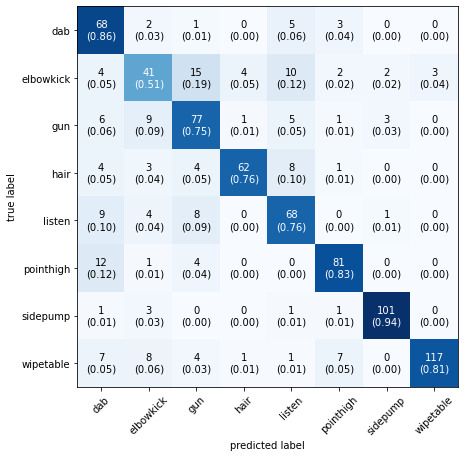

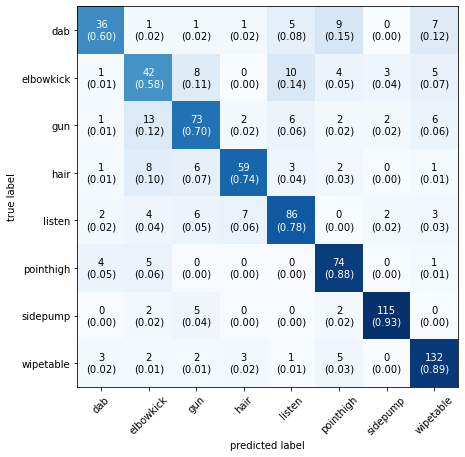

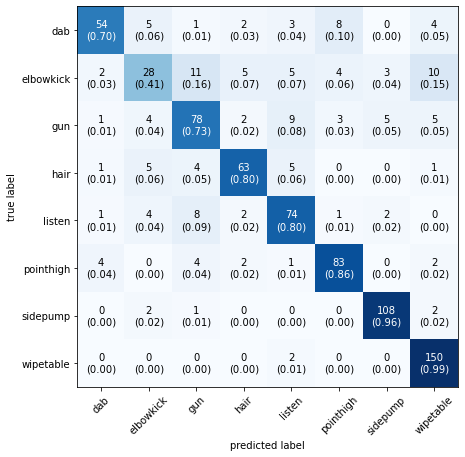

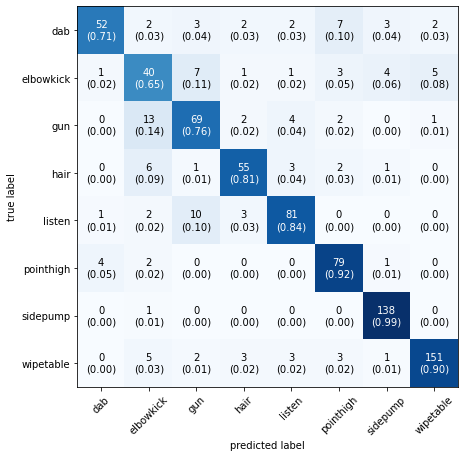

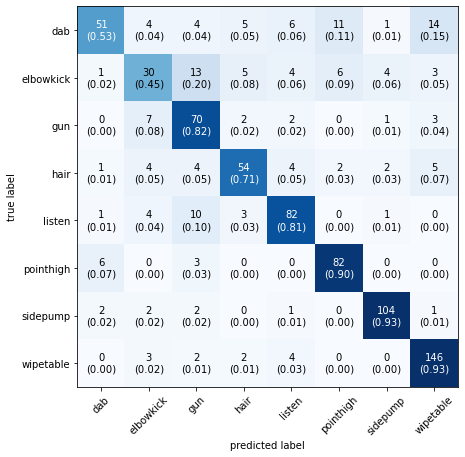

In [20]:
for i in range(5):
    plot_confusion_matrix(conf_mat=cm_hist[i], class_names=encoder.classes_, show_normed=True, 
                          figsize=(7,7), hide_spines=False)

### Classification Report of each training fold

In [21]:
for i in range(5):
    print("\nClassification Report for fold {}:" .format(i+1))
    print(classification_report_hist[i])


Classification Report for fold 1:
              precision    recall  f1-score   support

         dab       0.61      0.86      0.72        79
   elbowkick       0.58      0.51      0.54        81
         gun       0.68      0.75      0.72       102
        hair       0.91      0.76      0.83        82
      listen       0.69      0.76      0.72        90
   pointhigh       0.84      0.83      0.84        98
    sidepump       0.94      0.94      0.94       107
   wipetable       0.97      0.81      0.88       145

    accuracy                           0.78       784
   macro avg       0.78      0.78      0.77       784
weighted avg       0.80      0.78      0.79       784


Classification Report for fold 2:
              precision    recall  f1-score   support

         dab       0.75      0.60      0.67        60
   elbowkick       0.55      0.58      0.56        73
         gun       0.72      0.70      0.71       105
        hair       0.82      0.74      0.78        80
      li

In [ ]:
# curve_1 = np.linspace(1, mlp_sgd_model.n_iter_, mlp_sgd_model.n_iter_)
# curve_2 = np.linspace(1, mlp_adam_model.n_iter_, mlp_adam_model.n_iter_)

# plt.plot(curve_1, mlp_sgd_model.loss_curve_, label = 'SGD Convergence' )
# plt.plot(curve_2, pred_mlp_adam.loss_curve_, label = 'ADAM Convergence')
# plt.title('Error Convergence')
# plt.ylabel('Cost function')
# plt.xlabel('Iterations')
# plt.legend()
# plt.show()